# $E_{\text{peak}} - E_{\text{iso}}$ correlation
using $E_{\text{iso}} = 4\pi D_L^2 S / (1+z)$
where $$D_L(z) = (1+z) \frac{c}{H_0} \int_0 ^z \frac{dz^\prime}{\sqrt{\Omega_m (1+z^\prime)^3} + \Omega_{DE}} \quad; \Omega_r \sim \Omega_k = 0$$

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [75]:
# read data
df = pd.read_csv('table.csv')

def kev_to_ergs(col):
    # 1 erg = 10**-3 * 6.242*10**11 keV
    return np.array([val*6.242*10**8 for val in col])

Epeak = kev_to_ergs(df['Epeak'])
Epeak_err = kev_to_ergs(df['Epeak_err'])
z = df['z']
S = df['Fluence'] # ergs/cm2
S_err = df['Fluence_err']

In [76]:
# constants and equations
H0 = 70 # km/s/Mpc
H0 = 2.27 * (10**-18) # in cgs units
c = 29979245800 # cm/s

# predefined flat cosmology
Om = 0.3
Ode = 0.7

def luminosity_distance(redshift, H0=H0, Omega_m=Om, Omega_DE=Ode):
    def luminosity_distance_single(z, H0=H0, Omega_m=Om, Omega_DE=Ode):
        def integrand(z_prime, H0=H0, Omega_m=Om, Omega_DE=Ode):
            return 1/np.sqrt(Om*(1+z_prime)**3 + Ode)
        integral, _ = quad(integrand, 0, z, args=(H0, Om, Ode))
        return (c * (1+z)/H0) * integral
    return np.array([luminosity_distance_single(z_i, H0, Om, Ode) for z_i in redshift])

def isotropic_equivalent_energy(redshift, fluence, H0=H0, Omega_m=Om, Omega_DE=Ode):
    numerator = 4.*np.pi* (luminosity_distance(redshift, H0, Omega_m, Omega_DE)**2) *S
    return np.array(numerator/(1+z))

Next we'll try plotting $E_{\text{iso, S}}$ against $E_{\text{iso}}$ (the one in the table, having derived $E_{\text{iso,S}}$ from the fluence $S$, redshift $z$ and luminosity distance $D_L(z)$ with an assumed flat cosmology of $h = \Omega_{DE} = 0.7$. Additionally, we will use the equation $E_{\text{iso, S}} = 1 \cdot E_\text{iso}$ to find if our calculatiosn were good.

In [81]:
Eiso = isotropic_equivalent_energy(z, S, H0=H0, Omega_m=Om, Omega_DE=Ode)

[]

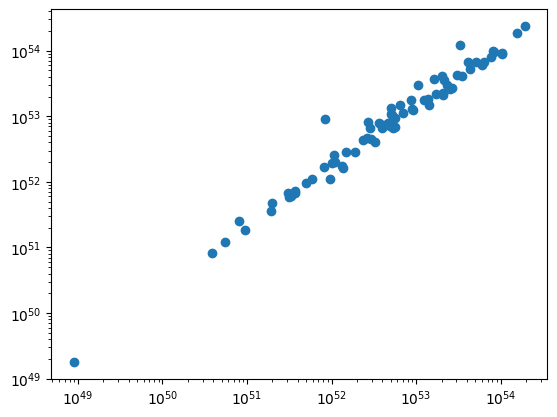

In [82]:
plt.figure()
plt.scatter(Eiso, df['Eiso'])
plt.loglog()

Text(0, 0.5, '$E_\\text{iso}$')

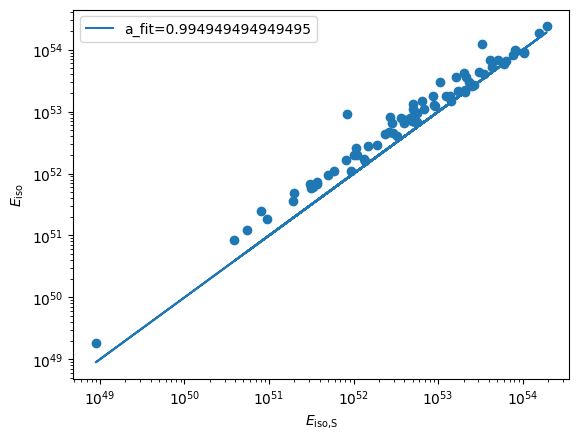

In [94]:
def GoF(a, x=Eiso, y=df['Eiso']):
    """
    Returns the sum of the squared errors for the fit.
    :param a: exponent
    :param x: x-values
    :param y: y-values
    :return: sum for least squares fit
    """
    model = x**a
    squares = (model-y)**2
    return np.sum(squares)

a = np.linspace(.5, 1.5, 100)

G = np.zeros(len(a))

for i in range(len(a)):
    G[i] = GoF(a[i])

best_fit = np.argmin(G)
a_index = np.unravel_index(best_fit, len(a))
a_fit = a[a_index]
plt.figure()
plt.scatter(Eiso, df['Eiso'])
plt.plot(Eiso, a_fit*Eiso, label=f'a_fit={a_fit}')

plt.loglog()
plt.legend()
plt.xlabel(r'$E_\text{iso,S}$')
plt.ylabel(r'$E_\text{iso}$')